## About Dataset


#### **Data Fields**

* datetime - hourly date + timestamp  
* season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
* holiday - whether the day is considered a holiday
* workingday - whether the day is neither a weekend nor holiday
* weather - 
    * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
* temp - temperature in Celsius
* atemp - "feels like" temperature in Celsius
* humidity - relative humidity
* windspeed - wind speed
* casual - number of non-registered user rentals initiated
* registered - number of registered user rentals initiated
* count - number of total rentals (Dependent Variable)

In [1]:
import os
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
import missingno as msno
from datetime import datetime as dt
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [2]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.metrics import mean_absolute_error

In [3]:
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV, GroupKFold
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.scorer import make_scorer

In [4]:
from datetime import datetime, timedelta, timezone

In [101]:
from tbats import BATS, TBATS
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

#### **Load dataset**

In [6]:
# os.getcwd()

In [7]:
dailyData = pd.read_csv("https://raw.githubusercontent.com/Sokolheavy/Python_DB_script/master/works_files/bikes_prediction/dailyData.csv", 
                        parse_dates = ['dteday'],
                        infer_datetime_format = True)   

In [8]:
dailyData.head()

,Unnamed: 0,dteday,season,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [9]:
dailyData.drop('Unnamed: 0', axis = 1, inplace = True)

## Data Summary

#### **Shape Of The Dataset**

In [10]:
dailyData.shape

(17379, 14)

#### **Sample Of First Few Rows**

#### **Variables Data Type**

In [11]:
dailyData.dtypes

dteday        datetime64[ns]
season                 int64
hr                     int64
holiday                int64
weekday                int64
workingday             int64
weathersit             int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object

In [12]:
dailyData.describe()

,season,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,1.106918,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,3.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,3.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,4.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


## Feature Engineering

#### **Creating New Columns From "Datetime" Column**

In [13]:
dailyData.rename(columns = {'dteday': 'date'}, inplace = True)

In [14]:
dailyData['week'] = pd.to_datetime(dailyData.date, '%G%V').dt.week
# dailyData['week2'] = dailyData.date.dt.week

In [15]:
dailyData['weekday'] = dailyData['date'].apply(lambda x: x.weekday())
dailyData['month'] = dailyData.date.dt.month
dailyData['workingday'] = np.where((dailyData.month > 5) | (dailyData.holiday == 1), 0, 1)
dailyData['year'] = dailyData.date.dt.year
dailyData['quarter'] = dailyData.date.dt.quarter
dailyData['season'] = dailyData.date.dt.month.apply(lambda x: (x%12 +3)//3)

In [16]:
dailyData['week_cat'] = dailyData['week'].astype(str)
dailyData['weekday_cat'] = dailyData['weekday'].astype(str)
dailyData['month_cat'] = dailyData['month'].astype(str)
dailyData['year_cat'] = dailyData['year'].astype(str)
dailyData['quarter_cat'] = dailyData['quarter'].astype(str)
dailyData['season_cat'] = dailyData['season'].astype(str) 

In [17]:
dailyData.dtypes

date           datetime64[ns]
season                  int64
hr                      int64
holiday                 int64
weekday                 int64
workingday              int32
weathersit              int64
temp                  float64
atemp                 float64
hum                   float64
windspeed             float64
casual                  int64
registered              int64
cnt                     int64
week                    int64
month                   int64
year                    int64
quarter                 int64
week_cat               object
weekday_cat            object
month_cat              object
year_cat               object
quarter_cat            object
season_cat             object
dtype: object

In [18]:
cat_var = list(dailyData.select_dtypes(include=['object']))

In [19]:
cat_var

['week_cat',
 'weekday_cat',
 'month_cat',
 'year_cat',
 'quarter_cat',
 'season_cat']

In [20]:
print('min_date: {:%d-%b-%Y}, max_date: {:%d-%b-%Y}'.format(dailyData['date'].min(), dailyData['date'].max()))

min_date: 01-Jan-2011, max_date: 31-Dec-2012


In [21]:
train_data = dailyData[dailyData['date'] <= '2012-05-31']
test_data = dailyData[dailyData['date'] > '2012-05-31']

### Additional Feature Engineering

In [22]:
def positive_min(x):
    return x[x > 0].min()

positive_min.__name__ = 'positive_min'

def positive_mean(x):
    return x[x > 0].mean()

positive_mean.__name__ = 'positive_mean'

def positive_median(x):
    return x[x > 0].median()

positive_median.__name__ = 'positive_median'

def positive_count(x):
    return x[x > 0].max()

positive_count.__name__ = 'positive_max'

In [23]:
for cat in cat_var:
    temp = dailyData.groupby([cat]).agg({'cnt':['mean', 'median', 'max']})
    temp.columns = temp.columns.map('.'.join)
    temp = temp.add_prefix(cat+'_').reset_index()
    historical_data = pd.merge(train_data, temp, how='left', on=[cat])
    test_data = pd.merge(test_data, temp, how='left', on=[cat])

In [24]:
comb = ['workingday']

In [25]:
temp = historical_data.groupby(comb + ['week_cat']).agg({"cnt": ['mean', 'median', 'max']}) # 'describe'
temp.columns = temp.columns.map('.'.join)
temp = temp.add_prefix('.'.join(comb) +'week_cat').reset_index()
historical_data = pd.merge(historical_data, temp, how='left', on=comb + ['week_cat'])
test_data = pd.merge(test_data, temp, how='left', on=comb + ['week_cat'])

In [26]:
temp = historical_data.groupby(comb + ['month_cat']).agg({"cnt": ['mean', 'median', 'max']}) # 'describe'
temp.columns = temp.columns.map('.'.join)
temp = temp.add_prefix('.'.join(comb) +'_month_cat').reset_index()
historical_data = pd.merge(historical_data, temp, how='left', on=comb + ['month_cat'])
test_data = pd.merge(test_data, temp, how='left', on=comb + ['month_cat'])

In [27]:
temp = historical_data.groupby(comb + ['quarter_cat']).agg({"cnt": ['mean', 'median', 'max']}) # 'describe'
temp.columns = temp.columns.map('.'.join)
temp = temp.add_prefix('.'.join(comb) +'_quarter_cat').reset_index()
historical_data = pd.merge(historical_data, temp, how='left', on=comb + ['quarter_cat'])
test_data = pd.merge(test_data, temp, how='left', on=comb + ['quarter_cat'])

In [28]:
temp = historical_data.groupby(comb + ['season_cat']).agg({"cnt": ['mean', 'median', 'max']}) # 'describe'
temp.columns = temp.columns.map('.'.join)
temp = temp.add_prefix('.'.join(comb) +'_season_cat').reset_index()
historical_data = pd.merge(historical_data, temp, how='left', on=comb + ['season_cat'])
test_data = pd.merge(test_data, temp, how='left', on=comb + ['season_cat'])

### Split train data:

In [29]:
test_size=0.25
np.asarray(test_size).dtype.kind

'f'

In [30]:
test_size=12
np.asarray(test_size).dtype.kind

'i'

In [31]:
train_groups = dailyData.date.sort_values(ascending=True).unique()

In [32]:
train_groups

array(['2011-01-01T00:00:00.000000000', '2011-01-02T00:00:00.000000000',
       '2011-01-03T00:00:00.000000000', '2011-01-04T00:00:00.000000000',
       '2011-01-05T00:00:00.000000000', '2011-01-06T00:00:00.000000000',
       '2011-01-07T00:00:00.000000000', '2011-01-08T00:00:00.000000000',
       '2011-01-09T00:00:00.000000000', '2011-01-10T00:00:00.000000000',
       '2011-01-11T00:00:00.000000000', '2011-01-12T00:00:00.000000000',
       '2011-01-13T00:00:00.000000000', '2011-01-14T00:00:00.000000000',
       '2011-01-15T00:00:00.000000000', '2011-01-16T00:00:00.000000000',
       '2011-01-17T00:00:00.000000000', '2011-01-18T00:00:00.000000000',
       '2011-01-19T00:00:00.000000000', '2011-01-20T00:00:00.000000000',
       '2011-01-21T00:00:00.000000000', '2011-01-22T00:00:00.000000000',
       '2011-01-23T00:00:00.000000000', '2011-01-24T00:00:00.000000000',
       '2011-01-25T00:00:00.000000000', '2011-01-26T00:00:00.000000000',
       '2011-01-27T00:00:00.000000000', '2011-01-28

In [33]:
def train_valid_split_byGroup(pdf, group_column, valid_size=0.25):
    # get all periods
    train_groups = pdf[group_column].sort_values(ascending=True).unique()
    # detect type of valid_size: float or integer
    valid_size_type = np.asarray(valid_size).dtype.kind
        
    if valid_size_type == 'f':
        spit_point = np.percentile(np.asarray(train_groups), 100-int(valid_size*100), interpolation='nearest')
    elif valid_size_type == 'i':
        spit_point = train_groups[-valid_size]
    else:
        raise ValueError("Invalid value for valid_size: {}".format(valid_size))
    
    return pdf[pdf[group_column] < spit_point], pdf[pdf[group_column] >= spit_point]

In [34]:
train_data, valid_data = train_valid_split_byGroup(train_data, 'date', valid_size=180)

In [35]:
train_data.shape

(7976, 24)

In [36]:
valid_data.shape

(4307, 24)

In [37]:
test_data.shape

(5096, 54)

In [38]:
dataDaily_origin = dailyData.copy()
train_origin = train_data.copy()
valid_origin = valid_data.copy()
test_origin = test_data.copy()

### Internal preprocessing:

In [39]:
numerical_features = [i for i in dailyData._get_numeric_data().columns if i not in 'cnt']

In [40]:
cat_var

['week_cat',
 'weekday_cat',
 'month_cat',
 'year_cat',
 'quarter_cat',
 'season_cat']

In [41]:
# Create standardizer
scaler = StandardScaler()

In [42]:
X_dailyData_num = dailyData[numerical_features]
X_train_num = train_data[numerical_features]
X_valid_num = valid_data[numerical_features]
X_test_num = test_data[numerical_features]

In [43]:
X_dailyData_num.fillna(X_dailyData_num.mean(),inplace=True)
X_train_num.fillna(X_dailyData_num.mean(),inplace=True)
X_valid_num.fillna(X_dailyData_num.mean(),inplace=True)
X_test_num.fillna(X_dailyData_num.mean(),inplace=True)

In [44]:
# Fit standardizer to training set
scaler.fit(X_dailyData_num)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [45]:
X_dailyData_num = scaler.transform(X_dailyData_num)
X_train_num = scaler.transform(X_train_num)
X_valid_num = scaler.transform(X_valid_num)

In [46]:
dailyData.loc[:, numerical_features] = X_dailyData_num
train_data.loc[:, numerical_features] = X_train_num
valid_data.loc[:, numerical_features] = X_valid_num

In [47]:
target = ['cnt']
times = ['date']

In [48]:
X_dailyData =  dailyData.loc[:, [i for i in dailyData.columns if (i not in target) & (i not in times)]] 
X_train = train_data.loc[:, [i for i in dailyData.columns if (i not in target) & (i not in times)]]
X_valid = valid_data.loc[:, [i for i in dailyData.columns if (i not in target) & (i not in times)]]
X_test = test_data.loc[:, [i for i in dailyData.columns if (i not in target) & (i not in times)]]

y_dailyData = dailyData[target[0]]
y_train = train_data[target[0]]
y_valid = valid_data[target[0]]
y_test = test_data[target[0]]

### prepare categorical input:

In [49]:
def add_missing_dummy_columns( d, columns ):
    missing_cols = set( columns ) - set( d.columns )
    for c in missing_cols:
        d[c] = 0

In [50]:
def fix_columns( d, columns ):  

    add_missing_dummy_columns( d, columns )

    # make sure we have all the columns we need
    assert( set( columns ) - set( d.columns ) == set())

    extra_cols = set( d.columns ) - set( columns )
    if extra_cols:
        print("extra columns: ", extra_cols)

    d = d[ columns ]
    return d

In [51]:
dailyData_df_cat = pd.get_dummies(X_dailyData[cat_var])
X_dailyData_dv = pd.concat([X_dailyData, dailyData_df_cat], axis=1)
X_dailyData_dv.drop(cat_var, axis=1,inplace=True)

In [52]:
train_df_cat = pd.get_dummies(X_train[cat_var])
X_train_dv = pd.concat([X_train, train_df_cat], axis=1)
X_train_dv.drop(cat_var, axis=1,inplace=True)

In [53]:
valid_df_cat = pd.get_dummies(X_valid[cat_var])
X_valid_dv = pd.concat([X_valid, valid_df_cat], axis=1)
X_valid_dv.drop(cat_var, axis=1, inplace=True)

In [54]:
test_df_cat = pd.get_dummies(X_test[cat_var])
X_test_dv = pd.concat([X_test, test_df_cat], axis=1)
X_test_dv.drop(cat_var, axis=1, inplace=True)

In [55]:
X_train_dv = fix_columns( X_train_dv, X_dailyData_dv.columns )
X_valid_dv = fix_columns( X_valid_dv, X_train_dv.columns )

In [56]:
X_test_dv = fix_columns( X_test_dv, X_dailyData_dv.columns )

#### LabelEncoding:

In [57]:
all_features = X_dailyData.columns
all_features_dv = X_dailyData_dv.columns

In [58]:
LE_mapper={}

for category in cat_var:
    LE_mapper[category]=LabelEncoder()
    X_dailyData[category]=LE_mapper[category].fit_transform(X_dailyData[category])

In [59]:
LE_mapper

{'week_cat': LabelEncoder(),
 'weekday_cat': LabelEncoder(),
 'month_cat': LabelEncoder(),
 'year_cat': LabelEncoder(),
 'quarter_cat': LabelEncoder(),
 'season_cat': LabelEncoder()}

In [60]:
for item in LE_mapper.items():
    category = item[0]
    le = item[1]
    
    X_train[category]=le.transform(X_train[category])
    X_valid[category]=le.transform(X_valid[category])

In [61]:
for item in LE_mapper.items():
    category = item[0]
    le = item[1]
    
    X_test[category] = pd.Series(le.transform(X_test[category][X_test[category].isin(le.classes_)]), index=X_test[category][X_test[category].isin(le.classes_)].index).reindex(X_test[category].index, fill_value=-1)

In [62]:
groups = dailyData['date'].values
train_groups = train_data['date'].values
group_kfold = GroupKFold(n_splits=5)

### Metrics:

In [63]:
def getMAD(forecast,sales):
    return (0 if sales==0 else 1) if forecast==0 else abs(sales-forecast)/forecast

In [64]:
def ape(y_true, y_pred): 
    return np.abs((sum(y_true) - sum(y_pred))/ sum(y_pred))*100

In [65]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred)) * 100 / np.mean(np.abs(y_true))

### Univariate:

In [71]:
dataDaily_origin['datetimes'] = dataDaily_origin.apply(lambda x: x[0] + timedelta(hours=x[2]), axis = 1)
train_origin['datetimes'] = train_origin.apply(lambda x: x[0] + timedelta(hours=x[2]), axis = 1)
valid_origin['datetimes'] = valid_origin.apply(lambda x: x[0] + timedelta(hours=x[2]), axis = 1)
test_origin['datetimes'] = test_origin.apply(lambda x: x[0] + timedelta(hours=x[2]), axis = 1)

In [72]:
dataDaily_origin.shape

(17379, 25)

In [73]:
train_origin.shape

(7976, 25)

In [77]:
data_un = dataDaily_origin[[
    'datetimes',
    'cnt',
]]

In [78]:
train_un = train_origin[[
    'datetimes',
    'cnt',
]]

In [79]:
valid_un = valid_origin[[
    'datetimes',
    'cnt',
]]

In [80]:
test_un = test_origin[[
    'datetimes',
    'cnt',
]]

In [81]:
data_un['cnt'].asfreq(freq='H').fillna(0, inplace = True)
train_un['cnt'].asfreq(freq='H').fillna(0, inplace = True)
valid_un['cnt'].asfreq(freq='H').fillna(0, inplace = True)
test_un['cnt'].asfreq(freq='H').fillna(0, inplace = True)

In [82]:
data_un['ds'] = data_un['datetimes']
train_un['ds'] = train_un['datetimes'] 
valid_un['ds'] = valid_un['datetimes']
test_un['ds'] = test_un['datetimes']

In [83]:
data_un.drop(['datetimes'], axis=1,inplace=True)
train_un.drop(['datetimes'], axis=1,inplace=True)
valid_un.drop(['datetimes'], axis=1,inplace=True)
test_un.drop(['datetimes'], axis=1,inplace=True)

In [84]:
data_un.set_index('ds', inplace=True)
train_un.set_index('ds', inplace=True)
valid_un.set_index('ds', inplace=True)
test_un.set_index('ds', inplace=True)

In [85]:
from tbats import BATS, TBATS

In [86]:
period = test_un.shape[0]
tbats_fit = TBATS(seasonal_periods = [365*24/4, 365*24]).fit(data_un['cnt'])
tbats_pred = tbats_fit.forecast(steps=period) 
tbats_pred[tbats_pred < 0] = 0

In [89]:
test_un.cnt.values

array([86, 34, 16, ..., 90, 61, 49], dtype=int64)

In [87]:
tbats_pred

array([51.54002744, 60.73362757, 68.04533131, ..., 93.95254515,
       93.95254515, 93.95254515])

In [90]:
ape(test_un.cnt.values, tbats_pred)

174.72834472945132

In [91]:
mape(test_un.cnt.values, tbats_pred)

78.14575455396086

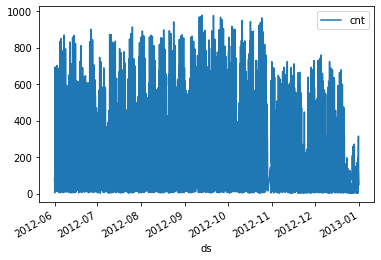

In [92]:
test_un.plot()

In [93]:
test_un['tbats_pred'] = tbats_pred

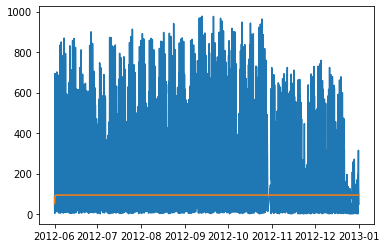

In [98]:
plt.plot(test_un.index, test_un.cnt)
plt.plot(test_un.index, test_un.tbats_pred)

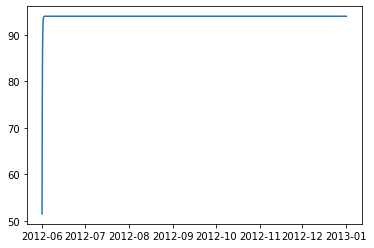

In [99]:
plt.plot(test_un.index, test_un.tbats_pred)

### Holt-Winters:

In [ ]:
period = test_un.shape[0]
tbats_fit = TBATS(seasonal_periods = [365*24/4, 365*24]).fit(data_un['cnt'])
tbats_pred = tbats_fit.forecast(steps=period) 
tbats_pred[tbats_pred < 0] = 0

In [114]:
hw_fit = ExponentialSmoothing(data_un['cnt'].astype('double'), seasonal_periods = 182*24 ,trend='add', seasonal='add',).fit()
# hw_pred0 = hw_fit.forecast(period)
hw_pred2 = hw_fit.forecast(period)

C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [111]:
hw_pred

17379       74.341757
17380      124.611183
17381      104.554730
17382       26.941629
17383       14.453369
17384       37.530539
17385       83.342572
17386       94.531029
17387       44.381703
17388      -33.095034
17389      -10.429665
17390        2.855474
17391      -16.223737
17392      -20.584102
17393      -11.575920
17394       17.132088
17395        7.696368
17396        3.672078
17397      -12.087550
17398      -11.747210
17399       -3.217549
17400        8.356313
17401       -4.359559
17402      -29.750109
17403       -5.839048
17404       -8.423719
17405      -45.710569
17406      -67.997357
17407      -72.836240
17408      -58.295701
             ...     
22445   -19302.139300
22446   -19298.039615
22447   -19292.928016
22448   -19344.179241
22449   -19350.714200
22450   -19349.653728
22451   -19351.018347
22452   -19343.596322
22453   -19387.419832
22454   -19409.861802
22455   -19407.921627
22456   -19373.710101
22457   -19389.028961
22458   -19426.099569
22459   -1

8760

### LSTM:

In [ ]:
def create_dataset(dataset, look_back=1):
    dataX, 